In [48]:

import warnings
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA



warnings.filterwarnings('ignore')

# Project Outline

In this project I will use be using a machine learning technique, Clustering. Clustering is an unsupervised learning method that takes several inputs and groups them based on the similarity(*an individual group*) and dissimilarity(*clusters*) of the data. It can be used to reveal underlying patterns within the data and provide greater insight.

In this project I will be clustering football players based on the characteristics given to each player in EA Sports' FIFA Football 19 computer game. The aim is that the information generated can be used by clubs to help guide their scouting and recruitment of players. The computer game [Football Manager](https://www.theguardian.com/technology/2014/aug/12/why-clubs-football-manager-scouting-tool) has previously been used to help football clubs recruit players. By using data from a computer game this should hopefully reveal unexpected similarities between players over the use of more traditional football data such as *number of shots*, *goals scored*, *tackles made etc*. 

The dataset is sourced from [Kaggle](https://www.kaggle.com/karangadiya/fifa19). It offers detailed information on every player registered on EA Sports' FIFA Football 19 computer game. It has details for over 18000 players however, to ease illustration I will only be using the top 500 valued players from the game. I have also excluded goalkeepers as if they were included two distinct groups were generated, outfield players and goalkeepers.

In [49]:
#Import the Fifa 19 dataset into a Dataframe. Remove any goalkeepers and select the top 500 players.
df = pd.read_csv("fifa.csv")
df = df[ (df['Position'] != 'GK')]
df = df.iloc[:500,:]
df = pd.DataFrame(df)
df.head()


,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M
5,5,183277,E. Hazard,27,https://cdn.sofifa.org/players/4/19/183277.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,91,Chelsea,...,91.0,34.0,27.0,22.0,11.0,12.0,6.0,8.0,8.0,€172.1M


### Transformation and weighting

The dataset is particularly extensive with over 89 columns for each player. A lot of these aren't suitable when clustering the data, such as their name and the FIFA's id for each player. 

FIFA 19 has 23 'attributional' fields.  Each player has been given a rating out of 100 for attributes like *Crossing, Jumping and, sprint speed*. I will cluster players based on these 23 fields. I have split these into 3 distinct groups; least important, moderately important, and very important. I have multiplied the variables, i.e. given them a weighting, in each group by a constant depending on the classification of importance.

In [50]:

group1 = df[['Volleys', 'Dribbling', 'Jumping', 'Penalties', 'FKAccuracy','Interceptions']] * 0.8
group2 = df[['Crossing', 'Finishing', 'Agility', 'Reactions', 'ShotPower',   'Positioning', 'Vision', 'Balance' ,'Composure', 'Marking', 'StandingTackle']]
group3 = df[['BallControl', 'Passing', 'SprintSpeed', 'Acceleration','Stamina', 'Strength']] * 1.2
X = group1.join(group2)
X = X.join(group3)
players=X # Players dataFrame to be used later

### Deciding upon number of clusters

I will use K-means clustering algorithm to find the clusters. I have used this algorithm as it is simple to understand and  fast. I will use the in-built sci-kit Kmeans library which is very fast and easy to implement. I have also written my own Kmeans class and I will go into more detail about Kmeans in that section.

An issue when using KMeans is deciding upon the number of clusters to group your data in. This is defined by the User but generally it isn't obvious what the ideal number of clusters(k) is. The Elbow method is an algorithm that gives the optimal number of clusters for your dataset. The Elbow method gives a distortion score, this is the sum of squared distances(SSE) from each data point to its assigned centre. This is essentially measuring intra-cluster variance. You want this to be as low as possible. The optimal number of clusters is at the point of the 'elbow' - this is made clear by the dotted vertical line - shown in the graph. The optimal number of clusters is where the SSE score is relatively low and increasing the k number has diminishing returns. The below graph shows the optimal k number for this dataset to be 9. 

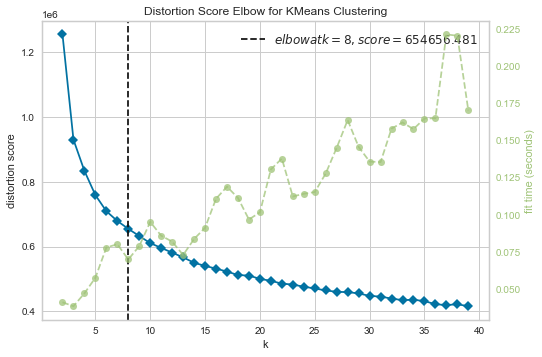

In [51]:

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,40))

visualizer.fit(X)        
visualizer.show()       

### Principal Component Analysis

Principal component analysis is a pre-processing technique performed on a dataset. It transforms our data, and orders attributes based on maximising variance. This can improve the performance of our clustering algorithm. 

One of its main functions is to reduce the dimensionality of the dataset.  The below graph shows the first principal component accounts for over 0.5% variance. The second principle component accounts for roughly 0.15% of variance.  I will reduce my dataset to these two components. 

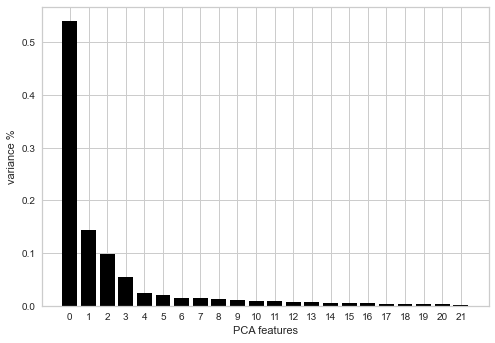

In [52]:
# Create a PCA instance: pca
pca = PCA(n_components=22)
principalComponents = pca.fit_transform(X)# Plot the explained variances
features = range(pca.n_components_)
pr = pca.explained_variance_ratio_
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

PCA_components = pd.DataFrame(principalComponents)

In [53]:
# Importing PCA 
from sklearn.decomposition import PCA 
  
# Let's say, components = 2 
pca = PCA(n_components = 2) 
pca.fit(X) 
x_pca = pca.transform(X) 
  


### Elbow method after PCA

After transforming my data using PCA there is a significant reduction in the distortion score (~200,000 from ~ 1,200,000). The optimal number of clusters is now 7.

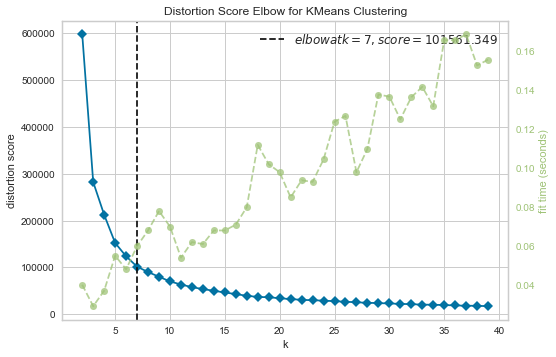

In [54]:

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,40))

visualizer.fit(x_pca)        
visualizer.show()       

### My own K_means implementation

##### My Algorithm: 

1. Decide number of clusters
2. Set initial random centroids
3. Cluster each datapoint to closest centroid using Euclidean distance metric
4. Compute new centroids using average data point of each cluster as new centroid
5. Reassign  each datapoint to closest centroid again using Euclidean distance
6. If no data points have been reassigned or number of iterations is equal to 200 then finish else complete steps 4 and 5 again

I have used Euclidean distance to measure similarities between the data: 


![](images/ed_equation.PNG)


My implementation tends to give the same results as the inbuilt sci-kit learn Kmeans. However, it has a couple of noticeable drawbacks. Firstly, on larger datasets it takes noticeably longer. This is because the in-built sci-kit learn implementation uses Elkan's algorithm which avoids unnecessary graph distance calculations [(Elkan's)](https://link.springer.com/chapter/10.1007/978-3-642-16773-7_2). The average time complexity for Scikit's Kmeans is given by O(k n T) where n is the number of samples and T is the number of iterations [(Scikit-learn)](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). Secondly, my implementation also suffers from the random initialisation trap. At the beginning of the algorithm initial centroids are randomly chosen in the graph space. However, this is done naively and can lead to generating incorrect clusters. I think therefore my implementation will sometimes give different results. However, the majority of the time it will give the same clusters. It may need to be run more than once.



In [55]:


class K_means_test():
    
    def __init__(self, k, dataset):
        self.k = k #number of clusters
        self.dataset = dataset #dataset as Dataframe
        self.centroids = [] #values of centroids
        self.previous_clusters = [] #group cluster number
        self.new_clusters = [] #new group cluster numbers
        self.number_of_col = len(self.dataset.columns) 
        self.number_of_rows = len(self.dataset)

   
    def initialise_centroids(self):
        for i in range(self.k):
            random_number = random.randrange(self.number_of_rows-1) # initialise k dataPoints as starting centroids
            self.centroids.append(self.dataset.iloc[random_number,:]) #Add these to centroids array          
        
    
    def euclidean_distance(self, index):
        distances_from_centroid = [] #Clear for each datapoint(rows)
        row = self.dataset.iloc[index, :].values #Take one row of values i.e. one Team        
        
        for a_centroid in self.centroids:
            total_distance = 0
            for j in range(self.number_of_col-1):
                total_distance += (float(row[j]) - float(a_centroid.iloc[j]))** 2  
            euclidean_distance = math.sqrt(total_distance)  
            distances_from_centroid.append(euclidean_distance)  #Append Euclidean Distance from each centroid
        
        cluster_no = (self.closest_centroid(distances_from_centroid)) #Return closest Centroid
        self.new_clusters.append(cluster_no) #append to array holding new_clusters
        self.dataset.at[index,'groups'] = cluster_no #add assigned group number to column groups in dataset
        
        
        
            
    def assign_datapoints(self):
        # Assign each datapoint to a cluster
        self.previous_clusters = self.new_clusters.copy() #copy old_cluster_groups to array.
        self.new_clusters = []
        for index in range(self.number_of_rows):
            self.euclidean_distance(index)
    
    def add_group_column_to_df(self):
        #Add group column to each row to hold assigneed cluster for each datapoint
        self.dataset["groups"] = 0
        self.number_of_col += 1       
       
    
    def closest_centroid(self, dist):
        #return index of closest centroid                 
        return dist.index(min(dist))

    def check_if_cluster_change(self):
        #check if cluster has changed if not stop else reassign datapoints
        if len(self.previous_clusters) == 0:
            return False
        return self.previous_clusters == self.new_clusters
            
    
    def calc_new_centroids(self):
        #Calculate new centroids. 
        self.centroids = []
        for i in range(self.k):
            s_df = self.dataset[self.dataset["groups"]==i] 
            new_centroids = s_df.mean()
            new_df = new_centroids.to_frame()        
            self.centroids.append(new_df)
            
                     
                           
    def fit(self):
        iterations = 0
        no_reassignment = False
        
        self.add_group_column_to_df()
        self.initialise_centroids()
        while not no_reassignment:
            self.assign_datapoints()
            self.calc_new_centroids()
            no_reassignment = self.check_if_cluster_change()
            iterations +=1
            if(iterations == 200): break;
        print("Number of Iterations", iterations)
        return self.new_clusters
        

In [56]:
#Convert x_pca to dataframe 
x_pca = pd.DataFrame(x_pca)


In [57]:
#Define k as 7 and run my own KMeans class
k = 7
km =  K_means_test(k, x_pca)
own_kmeans_impl = km.fit()

Number of Iterations 13


In [58]:
#Run Scikit-learns' KMeans
kmeans = KMeans(n_clusters = k, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(x_pca)

In [59]:
#convert centroids from own KMeans implementation from list to numpy array for plotting

centres = pd.DataFrame()
for i in range(k):
    centres = centres.append(km.centroids[i])
centres = centres.values
centres = np.reshape(centres,(k,3))


In [60]:
def scatter_plots(X, y_kmeans,centres, circles):
    fig, ax = plt.subplots(figsize=(8,6))
    col = ['red', 'blue', 'green', 'cyan', 'magenta', 'orange', 'purple']
    for i in range(k):
        ax.scatter(X[y_kmeans == i, 0], X[y_kmeans == i, 1], s = 10, c=col[i], label = 'Cluster{}'.format(i))
    ax.scatter(centres[:, 0], centres[:, 1], s = 50, c = 'yellow', label = 'Centroids')
    #Draw Circle around small cluster
    if(circles):
        circle = plt.Circle((56, 12.5), radius =7.5, lw = 5, color='red', fill=False)
        ax.add_artist(circle)
    ax.legend()

## Visualising the Clusters

Visualising the clusters can give you a quick idea of the performance of your algorithm. It is noticeable the clusters greater than 0 on the X-axis are tightly knitted and will, therefore, have low intra-cluster spread. The clusters which are below 0 on the X-axis are slightly more spread out. This suggests the players in these clusters will be less alike than the players in the more tightly knitted clusters.

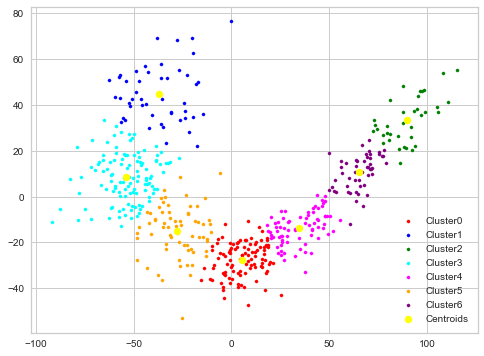

In [61]:
#Convert to numpy array for plotting
X= x_pca.values
#In-built scikit-learn results
scatter_plots(X, y_kmeans, kmeans.cluster_centers_,False)

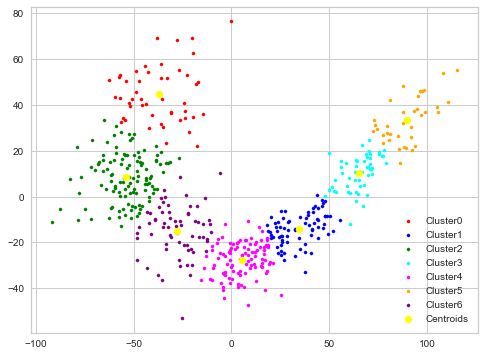

In [62]:
#convert list to numpy array for plotting
own_kmeans = np.asarray(own_kmeans_impl)
#My K_means class implementation
scatter_plots(X, own_kmeans, centres,False)

In [63]:
#Reset Index to ignore goalkeeper rows

players.reset_index(inplace=True)
df.reset_index(inplace=True)


In [64]:

#Create a Datafram with all 23 attributional fields + columns Value, Position, Age, Name + Prinicipal Componenet 1 and 2
add_col = ['Value', 'Position', 'Age', 'Name']
for col in add_col:
    players[col] = df[col]    
players[0] = km.dataset[0]
players[1] = km.dataset[1]


In [65]:
#Add column groups with assigned clusters for each player
players['Groups'] = own_kmeans

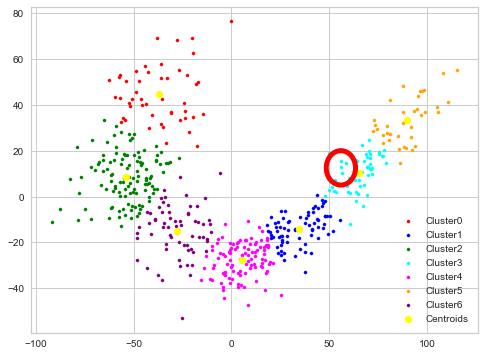

In [66]:
#Plot my implementation with circle around players to investigate further
scatter_plots(X, own_kmeans, centres,True)

I selected a small cluster to investigate further. 


The four players circled in red are Naldo, S.Mustafi, S.Nzonzi and J.Murillo. These are all similar types of players, with 3 of them playing in the same position,  so it looks like the model is giving the expected results. 

In [67]:
#Looking at small cluster
temp = players.loc[ ((players[0] < 60) &(players[0] > 50)) & ((players[1] >10) & (players[1] < 20)) ]
temp[['Name','Position','Groups']]

,Name,Position,Groups
90,Naldo,CB,3
243,S. Mustafi,RCB,3
248,S. Nzonzi,CDM,3
415,J. Murillo,LCB,3


## Defining Clusters

Investigating the results further suggest that the algorithm has generally grouped the clusters as to which position they play in. This is to be expected and suggests the model is working. To better illustrate  the makeup of each Cluster  I have written a function to draw a pie chart for each  cluster.

In [68]:
def pie_chart(cluster, index):
    # For Position column return a series containing unique values and their relative frequencies
    sizes = cluster['Position'].value_counts(normalize=True)    
    
    #Dictionary to hold values. Any Position with a realtive frequency less than 0.05 
    #will be added to small_values dictionary. These will be shown in 'Other' section of pie chart. 
    
    large_values = {}
    small_values ={}
    
    #Iterate over relative frequencies and add them to relevant dictionary
    for i,value in sizes.items():
        if value< 0.05:
            small_values[i] = value
        else:
            large_values[i] = value
    
    #Add all values from small_values dictionary and add label for this section
    if len(small_values) > 0:
        large_values['Other'] = sum(small_values.values())
        
    #Plot Pie Chart
    fig1, ax1 = plt.subplots(figsize=(6,6))
    ax1.pie(list(large_values.values()), labels=list(large_values.keys()), autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    print('\033[1m' + "Further detalis of 'Other' section, in cluster " + str(index) + ", for below Pie chart " + '\033[0m')
    for key,value in small_values.items():
        print (key + ": {:.1f}%".format(value*100))
    plt.show()
    

### Visualising positions of players in each cluster

As you can see from the pie charts below players are clustered in a way you might expect. There is one clear cluster of centre-backs(RCB, LCB, CB). This suggests the model is finding reasonable patterns in the data. If centre-backs were being clustered with strikers, this would be worrying. However, there are a few clusters where the player positions are more varied. For example one cluster has a number of Right-backs(RB's)  and Left-Backs(LB) in the same cluster as Central Attacking midfielders(CAM). You can probably glean from this that the RBs and LBs in this cluster are very attacking. Having very attacking full-back is common, and often desirable in modern football.

Further detalis of 'Other' section, in cluster 0, for below Pie chart 
CF: 2.1%
LW: 2.1%
RM: 2.1%
LCM: 2.1%


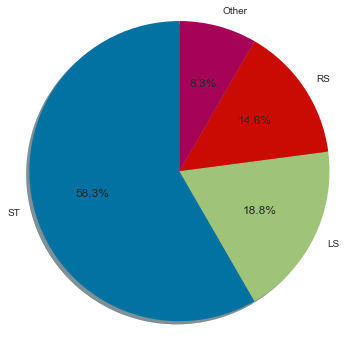

Further detalis of 'Other' section, in cluster 1, for below Pie chart 
RCM: 4.1%
CB: 2.7%
LM: 1.4%
LWB: 1.4%
RWB: 1.4%
LCM: 1.4%


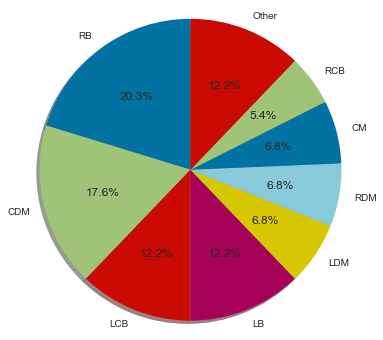

Further detalis of 'Other' section, in cluster 2, for below Pie chart 
CF: 2.6%
RS: 2.6%
RF: 2.6%
LF: 1.7%
RCM: 1.7%
LAM: 0.9%
LCM: 0.9%


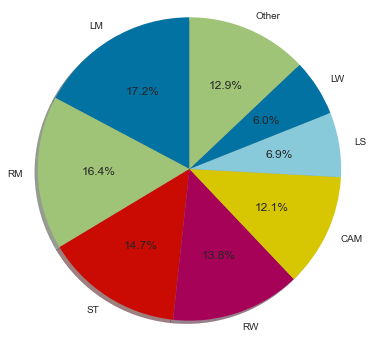

Further detalis of 'Other' section, in cluster 3, for below Pie chart 
LDM: 1.8%
RWB: 1.8%
LCM: 1.8%


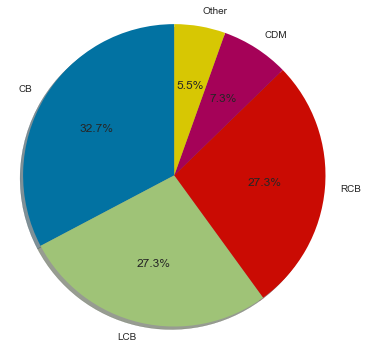

Further detalis of 'Other' section, in cluster 4, for below Pie chart 
LM: 3.8%
RDM: 2.9%
RM: 1.9%
RWB: 1.0%


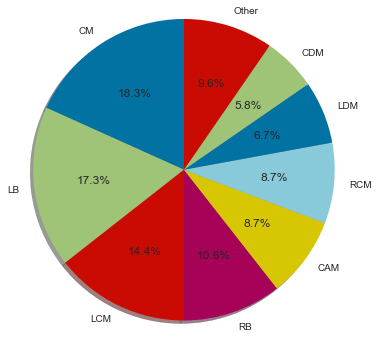

Further detalis of 'Other' section, in cluster 5, for below Pie chart 


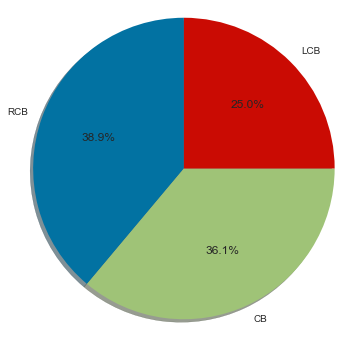

Further detalis of 'Other' section, in cluster 6, for below Pie chart 
ST: 4.5%
LW: 4.5%
RAM: 3.0%
LF: 3.0%
CF: 1.5%
RDM: 1.5%
LAM: 1.5%
LS: 1.5%


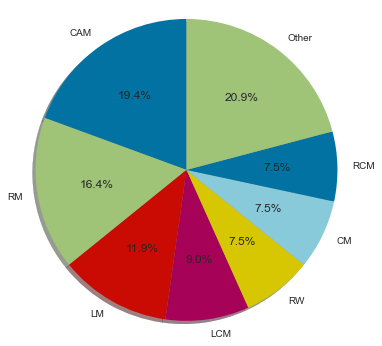

In [69]:
for i in range(k):
    cluster = players[players['Groups']== i]
    pie_chart(cluster, i)

### Further Exploration

In [70]:
#Remove currency character and M from value column. 
players['Value'] = players['Value'].apply(lambda x: x[1:-1])
#Any blank cell give a Value of 0.
players['Value'] = players['Value'].apply(lambda x: 0 if x == ' ' else x)

In [71]:
#Conver to numeric to find mean value of each cluster
players['Value'] = pd.to_numeric(players['Value'])

In [72]:
players.groupby('Groups').mean()[['Value', 'Age']]

,Value,Age
Groups,,
0,23.479167,27.708333
1,19.285135,27.878378
2,33.314655,26.896552
3,20.900000,27.472727
4,24.769231,27.000000
5,20.783333,28.138889
6,29.947761,27.074627


### Similar players

One of the ideas of the project was that it could be used to aid club recruitment. Below is a function that will return players plotted close to a given player on the graph. The lower the variance parameter given the more alike the players returned will be. 

For example, suppose Barcelona were looking to replace a 30-year-old Rakitic. They could use the function below to return similar players. This could be used to guide scouting etc. It is also hoped it may return players you may not expect. In the example below R.Guerreiro is returned. Rakitic and Guerreiro  would be considered to be quite different players. However, the model suggests they are quite similar. This could help clubs look at players they hadn't previously considered.

In [75]:
def similar_player(name, variance):
    player = players[players['Name']== name]
    
    x = player[0].iloc[0] # Position on scatter plot
    y = player[1].iloc[0]  #Position on scatter plot
    
    #Return list of players withinn variance given from original player
    temp = players.loc[ ((players[0] < (x+variance)) &(players[0] > (x-variance))) & ((players[1] >(y-variance)) & (players[1] < (y+variance))) ]
    return (temp)

In [76]:
similar_player('I. Rakitić', 7)

,index,Volleys,Dribbling,Jumping,Penalties,FKAccuracy,Interceptions,Crossing,Finishing,Agility,...,Acceleration,Stamina,Strength,Value,Position,Age,Name,0,1,Groups
9,11,65.6,64.8,24.0,58.4,67.2,65.6,88.0,76.0,70.0,...,76.8,90.0,87.6,76.5,LCM,28,T. Kroos,-4.222576,-40.885599,4
40,49,48.0,64.0,64.8,47.2,50.4,67.2,87.0,73.0,90.0,...,111.6,109.2,73.2,38.0,LB,29,Jordi Alba,-4.509133,-39.672222,4
43,52,63.2,68.8,56.8,56.0,57.6,57.6,78.0,79.0,76.0,...,82.8,100.8,80.4,46.5,LCM,30,M. Hamšík,-8.865649,-29.718396,4
44,53,64.0,67.2,31.2,65.6,67.2,60.0,84.0,83.0,72.0,...,79.2,100.8,79.2,46.5,RCM,30,I. Rakitić,-10.101244,-36.227270,4
75,86,44.8,65.6,48.8,47.2,60.8,52.8,86.0,72.0,74.0,...,85.2,108.0,94.8,45.0,LM,26,Koke,-3.199880,-34.166725,4
125,142,52.0,67.2,45.6,62.4,64.8,60.8,80.0,66.0,79.0,...,81.6,88.8,80.4,29.0,CDM,30,E. Banega,-3.686239,-33.702957,4
157,176,60.8,70.4,50.4,47.2,54.4,62.4,73.0,62.0,81.0,...,100.8,98.4,78.0,35.0,LCM,24,M. Kovačić,-4.308313,-33.537705,4
173,195,54.4,68.8,53.6,51.2,60.0,60.0,72.0,63.0,91.0,...,100.8,105.6,56.4,26.5,LCM,27,K. Kampl,-14.238406,-31.305584,4
222,258,69.6,62.4,59.2,60.8,63.2,62.4,77.0,70.0,87.0,...,103.2,108.0,80.4,20.5,RB,27,A. Florenzi,-10.774556,-35.772232,4
246,284,62.4,66.4,55.2,54.4,62.4,57.6,82.0,70.0,77.0,...,90.0,100.8,79.2,22.0,CM,28,G. Bonaventura,-9.221534,-31.156482,4


### Evaluation

This has been an interesting project to do. It has helped me become familiar with Python and some of its libraries. It has also helped me to better understand clustering and its implementation. 

Clustering is often used to label and define data. For example, if you have data on songs, such as *beats per minute, length, and Artist*, but it hasn't been given a genre and one needs to be defined, a clustering algorithm could provide a quick and effective way to do this . In this project it could be argued players are already 'labelled' by their position, and it is true most of the clusters are dominated players in one or two position. However, the aim of the project was to show a clustering algorithm. Also, I believe new insights could be gleaned with further data exploration combined with relavent football knowledge.